# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

2.0.0
/Users/shui/Desktop/BSC/UT-TOR-DATA-PT-01-2020-U-C-Master/23-Final-Project: ['.DS_Store', '1', 'machine-learning-project', '2']
/Users/shui/Desktop/BSC/UT-TOR-DATA-PT-01-2020-U-C-Master/23-Final-Project/machine-learning-project: ['stock_prediction_amazon.ipynb', 'raw_stock', '.DS_Store', 'stock_prediction_apple.ipynb', 'predicted_stock', 'stock_prediction_facebook.ipynb', 'stock.ipynb', 'stock_prediction_microsoft.ipynb', 'stock_prediction_tesla.ipynb', 'README.md', 'stock_prediction_google.ipynb', '.ipynb_checkpoints', '.git']


# 2. Analyze Data

In [2]:
# import all stock prices 
df = pd.read_csv("data/raw_stock/apple_stock.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 11 columns):
Date            1511 non-null object
Open            1511 non-null float64
High            1511 non-null float64
Low             1511 non-null float64
Close           1511 non-null float64
Volume          1511 non-null int64
Dividends       1511 non-null float64
Stock Splits    1511 non-null int64
Change          1511 non-null float64
%Change         1511 non-null object
Result          1511 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 130.0+ KB


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,%Change,Result
0,2014-07-22,85.75,85.94,85.25,85.79,55197000,0.0,0,0.04,0.05%,1.0
1,2014-07-23,86.42,88.65,86.20,88.03,92918000,0.0,0,1.61,1.86%,1.0
2,2014-07-24,87.89,88.14,87.33,87.88,45729000,0.0,0,-0.01,-0.01%,0.0
3,2014-07-25,87.72,88.62,87.53,88.46,43469000,0.0,0,0.74,0.84%,1.0
4,2014-07-28,88.60,89.88,88.35,89.68,55318000,0.0,0,1.08,1.22%,1.0


In [22]:
#df = df.drop(['Dividends','Stock Splits'],1,inplace=True)
#df.describe()
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df.reset_index(drop = True, inplace = True)
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,%Change,Result
1506,2020-07-15,395.96,396.99,385.96,390.90,38299500,0.0,0,-5.06,-1.28%,0.0
1507,2020-07-16,386.25,389.62,383.62,386.09,27644400,0.0,0,-0.16,-0.04%,0.0
1508,2020-07-17,387.95,388.59,383.36,385.31,23046700,0.0,0,-2.64,-0.68%,0.0
1509,2020-07-20,385.67,394.00,384.25,393.43,22531700,0.0,0,7.76,2.01%,1.0
1510,2020-07-21,396.69,397.00,386.99,388.00,25207600,0.0,0,-8.69,-2.19%,0.0


/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


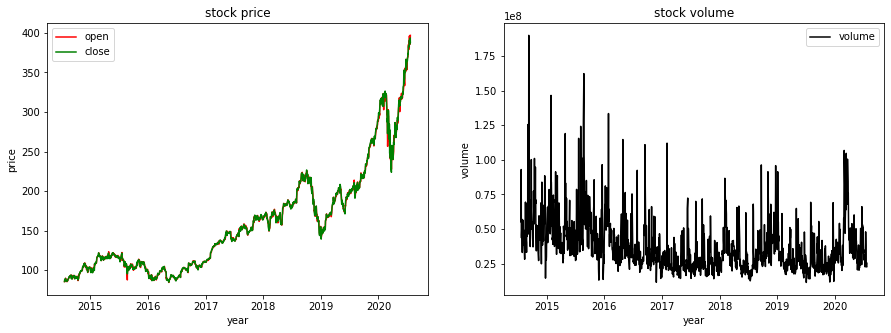

In [4]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Date, df.Open.values, color='red', label='open')
plt.plot(df.Date, df.Close.values, color='green', label='close')
#plt.plot(df.Low.values, color='blue', label='low')
#plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('year')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Date, df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('year')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate Data

In [5]:
# function for min-max normalization of stock
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    return df

In [6]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [7]:
# choose one stock
df_stock = df.copy()
df_stock.drop(['Date'],1,inplace=True)
df_stock.drop(['Volume'],1,inplace=True)
df_stock.drop(['Dividends'],1,inplace=True)
df_stock.drop(['Stock Splits'],1,inplace=True)
df_stock.drop(['Change'],1,inplace=True)
df_stock.drop(['%Change'],1,inplace=True)
df_stock.drop(['Result'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
#df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock)
df_stock_norm

# create train, test data
seq_len = 20 # choose sequence length
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(df_stock_norm, seq_len)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['Open', 'High', 'Low', 'Close']
X_train.shape =  (1193, 19, 4)
y_train.shape =  (1193, 4)
X_valid.shape =  (149, 19, 4)
y_valid.shape =  (149, 4)
X_test.shape =  (149, 19, 4)
y_test.shape =  (149, 4)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


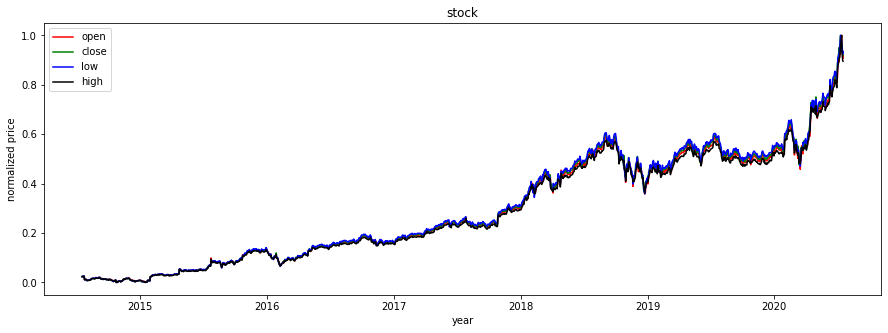

In [22]:
plt.figure(figsize=(15, 5));
plt.plot(df.Date, df_stock_norm.Open.values, color='red', label='open')
plt.plot(df.Date, df_stock_norm.Close.values, color='green', label='close')
plt.plot(df.Date, df_stock_norm.Low.values, color='blue', label='low')
plt.plot(df.Date, df_stock_norm.High.values, color='black', label='high')
#plt.plot(df.index, df_stock_norm.Volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('year')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

In [30]:
normalized_df = df_stock_norm
normalized_df.index = df.Date
normalized_df
normalized_df.to_csv("data/normalized_stock/apple_stock.csv")

# 4. Model and Validate Data

In [8]:
index_in_epoch = 0;
perm_array  = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, X_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > X_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [9]:
import tensorflow.compat.v1 as tf_v1
tf_v1.disable_v2_behavior() ##print(tf.__version__)
# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

tf_v1.reset_default_graph()

X = tf_v1.placeholder(tf_v1.float32, [None, n_steps, n_inputs])
y = tf_v1.placeholder(tf_v1.float32, [None, n_outputs])


Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
from tensorflow.keras.layers import Dense
# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf_v1.nn.elu)
#          for layer in range(n_layers)]
layers = [tf_v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf_v1.nn.elu)
          for layer in range(n_layers)]
# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                           

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [11]:
multi_layer_cell = tf_v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf_v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf_v1.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf_v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf_v1.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [12]:
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf_v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
         
# run graph
with tf_v1.Session() as sess: 
    sess.run(tf_v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        X_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: X_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: X_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: X_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: X_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: X_test})

0.00 epochs: MSE train/valid = 0.281126/0.684800
4.99 epochs: MSE train/valid = 0.000141/0.000433
9.97 epochs: MSE train/valid = 0.000113/0.000296
14.96 epochs: MSE train/valid = 0.000096/0.000388
19.95 epochs: MSE train/valid = 0.000102/0.000507
24.94 epochs: MSE train/valid = 0.000089/0.000449
29.92 epochs: MSE train/valid = 0.000056/0.000210
34.91 epochs: MSE train/valid = 0.000056/0.000143
39.90 epochs: MSE train/valid = 0.000073/0.000326
44.89 epochs: MSE train/valid = 0.000060/0.000127
49.87 epochs: MSE train/valid = 0.000050/0.000119
54.86 epochs: MSE train/valid = 0.000052/0.000228
59.85 epochs: MSE train/valid = 0.000068/0.000124
64.84 epochs: MSE train/valid = 0.000041/0.000097
69.82 epochs: MSE train/valid = 0.000047/0.000118
74.81 epochs: MSE train/valid = 0.000038/0.000110
79.80 epochs: MSE train/valid = 0.000039/0.000094
84.79 epochs: MSE train/valid = 0.000051/0.000206
89.77 epochs: MSE train/valid = 0.000037/0.000123
94.76 epochs: MSE train/valid = 0.000040/0.000086
99.

# 5. Predictions

In [13]:
y_train_pred.shape

(1193, 4)

In [21]:
y_test.shape

(149, 4)

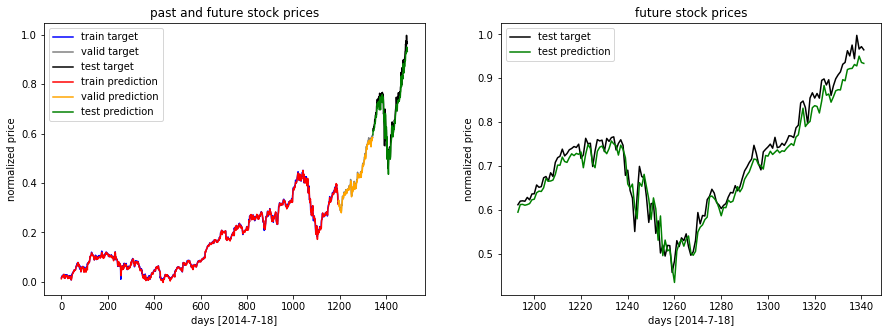

In [17]:
ft = 0 # 0 = open, 1 = highest, 2 = lowest, 3 = close

## show predictions

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
        color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('days [2014-7-18]')
plt.ylabel('normalized price')
plt.legend(loc='best');
plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('days [2014-7-18]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [28]:
target_data = np.array([*y_train, *y_valid, *y_test])
target_df = pd.DataFrame({'Open': target_data[:, 0], 'High': target_data[:,1], 
                             'Low': target_data[:,2], 'Close': target_data[:,3]})

target_df.index = df.Date[20:]
target_df.to_csv("data/target_stock/apple_stock.csv")

In [29]:
predicted_data = np.array([*y_train_pred, *y_valid_pred, *y_test_pred])
predicted_df = pd.DataFrame({'Open': predicted_data[:, 0], 'High': predicted_data[:,1], 
                             'Low': predicted_data[:,2], 'Close': predicted_data[:,3]})

predicted_df.index = df.Date[20:]
predicted_df.to_csv("data/predicted_stock/apple_stock.csv")

In [15]:
corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

correct sign prediction for close - open price for train/valid/test: 0.73/0.60/0.57
